## Detect occupational bias in different sentiment models

At least check these:
* BERT Tone
* XLM Roberta
* DA SpaCy sentiment 

Maybe also:
* Senda

### Example from https://www.kaggle.com/code/hamelg/python-for-data-26-anova
* What should data look like?
* How can we perform ANOVA?
    * I think I prefer the first way as it's closer to the R-syntax that I'm used to :)

In [1]:
# import numpy as np
# np.random.seed(12)
# import scipy.stats as stats
# import pandas as pd

# races =   ["asian","black","hispanic","other","white"]

# # Generate random data
# voter_race = np.random.choice(a= races,
#                               p = [0.05, 0.15 ,0.25, 0.05, 0.5],
#                               size=1000)

# voter_age = stats.poisson.rvs(loc=18,
#                               mu=30,
#                               size=1000)

# # Group age data by race
# voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
# groups = voter_frame.groupby("race").groups
# voter_frame

In [2]:
# # one method
# import statsmodels.api as sm
# from statsmodels.formula.api import ols # ordinary least squares

# model = ols('age ~ race',                 # Model formula
#             data = voter_frame).fit()
                
# anova_result = sm.stats.anova_lm(model, typ=2)
# print (anova_result)


# # The general structure for entering the equation is:
# # ols("outcome_variable ~ independent_variable", data= data_frame).fit()

In [3]:
# # another method
# # Etract individual groups
# asian = voter_age[groups["asian"]]
# black = voter_age[groups["black"]]
# hispanic = voter_age[groups["hispanic"]]
# other = voter_age[groups["other"]]
# white = voter_age[groups["white"]]

# # Perform the ANOVA
# stats.f_oneway(asian, black, hispanic, other, white)

### Imports

In [24]:
from danlp.models import load_bert_tone_model # BERT Tone
import operator # for the SpaCy model
import spacy # SpaCy model
from transformers import pipeline # for the XLM Roberta model
from typing import List, Dict
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.formula.api import ols # ordinary least squares
import numpy as np
import researchpy as rp
import scipy.stats as stats
import matplotlib.pyplot as plt
import scikit_posthocs as sp
tqdm.pandas()

ALPHA = 0.05

In [2]:
# utils functions

# for use with roberta
def convert_to_label_score_dict(top_k_list:List[Dict[str,str]]) -> dict: 
    """Convert a list of top-k probabilities (each being a dict of label and score) into a dictionary of the format {label: score}.

    Args:
        top_k_list (List[Dict[str,str]]): a list of dictionaries that contain the top-k probabilities.

    Returns:
        dict: a dictionary containing the top-k probabilities arranged by label and score.
    """
    new_dict = {}
    for proba_dict in top_k_list:
        new_dict[proba_dict["label"].lower()] = proba_dict["score"]
    return new_dict

### Load models

In [3]:
# spacy
spacy_clf = spacy.load("da_spacy_sentiment")

# bert tone
bert_clf = load_bert_tone_model()

# roberta
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
roberta_clf = pipeline("text-classification", model=model_path, tokenizer=model_path)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.2+cu121 with CUDA 1201 (you have 2.1.2+cpu)
    Python  3.9.13 (you have 3.9.18)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


### Load gender corpus

In [4]:
# load gender corpus
corpus = pd.read_excel("gender_corpus.xlsx")
corpus.head()

,identity_term_DA,identity_term_EN,gender,job_title_DA,job_title_EN,gender_distribution,sentence_DA,sentence_EN
0,androgynen,the androgynous person,Q,bager,baker,female-dominated,Androgynen er bager.,The androgynous person is a(n) baker.
1,androgynen,the androgynous person,Q,bibliotekar,librarian,female-dominated,Androgynen er bibliotekar.,The androgynous person is a(n) librarian.
2,androgynen,the androgynous person,Q,optiker,optician,female-dominated,Androgynen er optiker.,The androgynous person is a(n) optician.
3,androgynen,the androgynous person,Q,boghandler,bookseller,female-dominated,Androgynen er boghandler.,The androgynous person is a(n) bookseller.
4,androgynen,the androgynous person,Q,praktiserende læge,general practitioner,female-dominated,Androgynen er praktiserende læge.,The androgynous person is a(n) general practit...


### Pseudo-code

I need data that contains the "predicted positive class probability" and the gender of the noun phrase for each of the 2,400 sentences. They should be in a df, each row representing a sentence. To get this, I need to run each model on the synthetic data.

**Consider lowering and removing the punctuation! No, both K&M and B&B use normal sentences (capital first letter, full stop at the end)**

### Predict the class probabilities

In [5]:
def predict_class_probas(data:pd.DataFrame, model, model_name:str) -> pd.DataFrame:
    """Predict the positive, neutral, and negative class probabilities using a provided sentiment analysis model.

    Args:
        data (pd.DataFrame): the sentences should be in the column with index 1.
        model: the sentiment analysis model
        model_name (str): the name/type of model. Options: ['spacy', 'bert_tone', 'roberta'].

    Raises:
        Exception: If unknown model type is specified.

    Returns:
        pd.DataFrame: the data with the predicted class probabilities.
    """
    data["pos_proba"], data["neu_proba"], data["neg_proba"] = np.nan, np.nan, np.nan # initiate empty columns
    
    for i in tqdm(range(len(data))):
        sentence = data.iloc[i, 1]
        
        # score sentences using the specific system
        if model_name.lower() == "spacy":
            probas = model(sentence).cats
            pos, neu, neg = probas["positive"], probas["neutral"], probas["negative"]
        elif model_name.lower() == "bert_tone":
            pos, neu, neg = model.predict_proba(sentence)[0] # order can be seen using clf._classes() -- ['positive', 'neutral', 'negative']
        elif model_name.lower() == "roberta":
            probas_list = model(sentence, top_k=None) # list of top-k probas
            probas = convert_to_label_score_dict(probas_list) # convert to similar format as that of the spacy model
            pos, neu, neg = probas["positive"], probas["neutral"], probas["negative"]
        else:
            raise Exception("Unrecognized model name. Choose 'spacy', 'bert_tone', or 'roberta'.")
        
        # add to dataframe
        data.iloc[i, 2] = pos
        data.iloc[i, 3] = neu
        data.iloc[i, 4] = neg
    
    return data

In [6]:
# SpaCy model (< 1 min)

spacy_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
spacy_df = predict_class_probas(data=spacy_df, model=spacy_clf, model_name="spacy")

spacy_df.head()

  0%|          | 9/2400 [00:00<00:58, 40.70it/s]

100%|██████████| 2400/2400 [00:49<00:00, 48.05it/s]


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.317297,0.230019,0.452684
1,Q,Androgynen er bibliotekar.,0.686757,0.198589,0.114655
2,Q,Androgynen er optiker.,0.180639,0.803542,0.015819
3,Q,Androgynen er boghandler.,0.018917,0.010869,0.970215
4,Q,Androgynen er praktiserende læge.,0.503245,0.459390,0.037365


In [8]:
# BERT Tone (5-6 mins)

bert_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
bert_df = predict_class_probas(data=bert_df, model=bert_clf, model_name="bert_tone")

bert_df.head()

100%|██████████| 2400/2400 [06:17<00:00,  6.35it/s]


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.001226,0.997965,0.000809
1,Q,Androgynen er bibliotekar.,0.001020,0.998033,0.000946
2,Q,Androgynen er optiker.,0.001172,0.997997,0.000831
3,Q,Androgynen er boghandler.,0.000811,0.997627,0.001561
4,Q,Androgynen er praktiserende læge.,0.000447,0.998465,0.001088


In [9]:
# XLM Roberta (2-3 mins)

roberta_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
roberta_df = predict_class_probas(data=roberta_df, model=roberta_clf, model_name="roberta")

roberta_df.head()

  0%|          | 1/2400 [00:00<06:40,  5.99it/s]

100%|██████████| 2400/2400 [03:00<00:00, 13.29it/s]


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.006356,0.895560,0.098084
1,Q,Androgynen er bibliotekar.,0.008292,0.986916,0.004792
2,Q,Androgynen er optiker.,0.006736,0.989384,0.003880
3,Q,Androgynen er boghandler.,0.005188,0.989231,0.005580
4,Q,Androgynen er praktiserende læge.,0.008469,0.986922,0.004609


### ANOVAs

1) Fit model
2) Check assumptions
3) Conduct ANOVA or Kruskal-Wallis test
4) Conduct post-hoc tests

In [10]:
def check_normality(model, alpha:float=ALPHA, plot:bool=True) -> bool:
    """Return true and (test statistic, pvalue) if normality assumption is satisfied."""
    res = stats.shapiro(model.resid) # (W-test statistic, p-value)
    satisfied = res.pvalue >= alpha
    
    if plot:
        fig = plt.figure(figsize=(4,4))
        normality_plot, stat = stats.probplot(model.resid, plot=plt, rvalue=True)
        plt.title("Probability plot of model residuals")
        plt.show()
        
    return satisfied, res

def check_homogeneity(data, proba_colname, alpha:float=ALPHA, plot:bool=True) -> bool:
    """Return true and (test statistic, pvalue) if homogeneity of variance assumption is satisfied."""
    res = stats.levene(
        data[proba_colname][data["gender"] == "F"],
        data[proba_colname][data["gender"] == "M"],
        data[proba_colname][data["gender"] == "Q"]
        )
    satisfied = res.pvalue >= alpha
    
    if plot:
        plt.figure(figsize=(4,4))
        plot_data = [data[proba_colname][data["gender"] == "F"],
                data[proba_colname][data["gender"] == "M"],
                data[proba_colname][data["gender"] == "Q"]]
        plt.boxplot(plot_data, labels=['female', 'male', 'other'], showmeans=True)
        plt.title(f"Boxplot of {proba_colname} by gender")
        plt.xlabel("Gender")
        plt.ylabel("Predicted positive class probability")
        plt.show()
        
    return satisfied, res

#### SpaCy model

In [11]:
# check data types
spacy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       2400 non-null   object 
 1   sentence_DA  2400 non-null   object 
 2   pos_proba    2400 non-null   float64
 3   neu_proba    2400 non-null   float64
 4   neg_proba    2400 non-null   float64
dtypes: float64(3), object(2)
memory usage: 93.9+ KB


POS_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.3624,0.2646,0.0054,0.3518,0.373


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.3499,0.2545,0.0090,0.3322,0.3675
M,800,0.3856,0.2686,0.0095,0.3669,0.4042
Q,800,0.3517,0.2692,0.0095,0.3330,0.3704


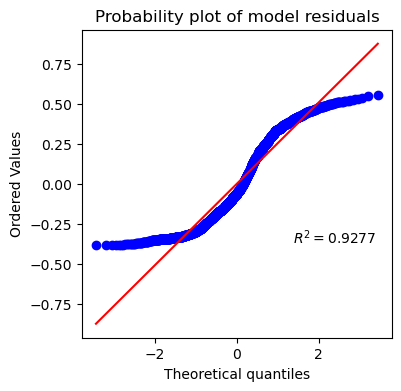

Normality assumption satisfied: False
ShapiroResult(statistic=0.9268395900726318, pvalue=1.0451825735731812e-32)


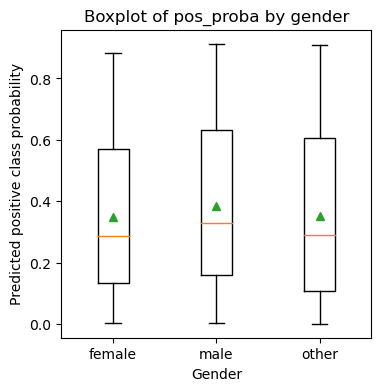

Homogeneity assumption satisfied: True
LeveneResult(statistic=2.8817304092960634, pvalue=0.05623187748159622)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 9.926251858601063
p = 0.006991040143498195
significant = True
__________________________________________________


NEU_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.4775,0.2782,0.0057,0.4664,0.4886


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.4865,0.2650,0.0094,0.4681,0.5049
M,800,0.4454,0.2762,0.0098,0.4263,0.4646
Q,800,0.5006,0.2903,0.0103,0.4804,0.5207


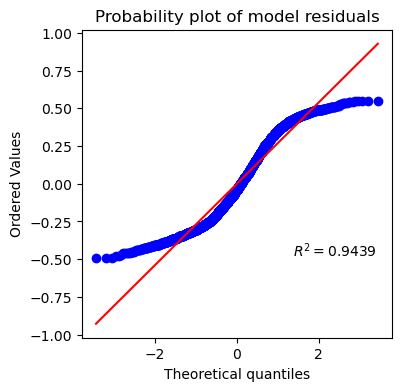

Normality assumption satisfied: False
ShapiroResult(statistic=0.9431254863739014, pvalue=1.8695894217398947e-29)


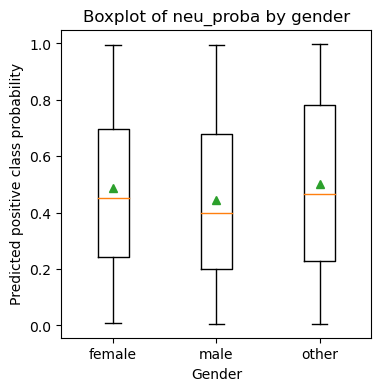

Homogeneity assumption satisfied: False
LeveneResult(statistic=8.349988171313486, pvalue=0.00024334381153828)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 17.319320184297794
p = 0.00017344325160799655
significant = True
__________________________________________________


NEG_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.1601,0.1971,0.004,0.1522,0.168


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.1637,0.1928,0.0068,0.1503,0.1770
M,800,0.1690,0.2056,0.0073,0.1547,0.1832
Q,800,0.1477,0.1923,0.0068,0.1344,0.1611


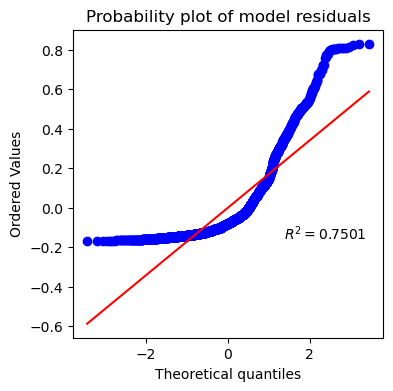

Normality assumption satisfied: False
ShapiroResult(statistic=0.7498776912689209, pvalue=0.0)


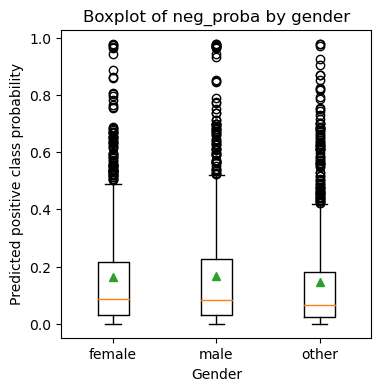

Homogeneity assumption satisfied: True
LeveneResult(statistic=1.540080819384919, pvalue=0.21457581375537557)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 11.000519346105648
p = 0.004085710351822214
significant = True
__________________________________________________




In [13]:
# SpaCy
for sent_class in ["pos_proba", "neu_proba", "neg_proba"]:
    print(sent_class.upper())
    
    # inspect data (overall and by gender)
    display(rp.summary_cont(spacy_df[sent_class]))
    display(rp.summary_cont(spacy_df[sent_class].groupby(spacy_df["gender"])))

    # define and fit model
    model = ols(f"{sent_class} ~ gender", data=spacy_df).fit() # fit model

    # check assumptions
    # independence - assumed OK

    # normality 
    normality, n_res = check_normality(model, ALPHA, plot=True)
    print("Normality assumption satisfied:", normality)
    print(n_res)

    # homogeneity of variance
    homogeneity, h_res = check_homogeneity(spacy_df, sent_class)    
    print("Homogeneity assumption satisfied:", homogeneity)
    print(h_res)

    # statistical testing
    # divide data by gender
    female = spacy_df[spacy_df["gender"] == "F"][sent_class]
    male = spacy_df[spacy_df["gender"] == "M"][sent_class]
    queer = spacy_df[spacy_df["gender"] == "Q"][sent_class]
    
    print("_"*50)
    
    if normality == False or homogeneity == False: # if at least one assumption is not met:
        print("\nASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST") # https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/kruskal-wallis/
        test_statistic, p = stats.kruskal(female, male, queer) # test statistic is called "H" here
    elif normality == True and homogeneity == True:
        print("\nASSUMPTIONS MET --> ANOVA")
        test_statistic, p = stats.f_oneway(female, male, queer) # test statistic is called "F" here
    print("statistic =", test_statistic)
    print("p =", p)
    print("significant =", p < 0.05)
    
    print("_"*50)
    print("\n")

#### BERT Tone model

In [14]:
# check data types
bert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       2400 non-null   object 
 1   sentence_DA  2400 non-null   object 
 2   pos_proba    2400 non-null   float64
 3   neu_proba    2400 non-null   float64
 4   neg_proba    2400 non-null   float64
dtypes: float64(3), object(2)
memory usage: 93.9+ KB


POS_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.034,0.1529,0.0031,0.0278,0.0401


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0115,0.0549,0.0019,0.0077,0.0153
M,800,0.0039,0.0149,0.0005,0.0029,0.0049
Q,800,0.0864,0.2505,0.0089,0.0691,0.1038


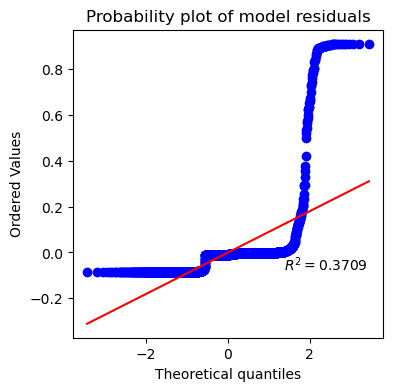

Normality assumption satisfied: False
ShapiroResult(statistic=0.3713873624801636, pvalue=0.0)


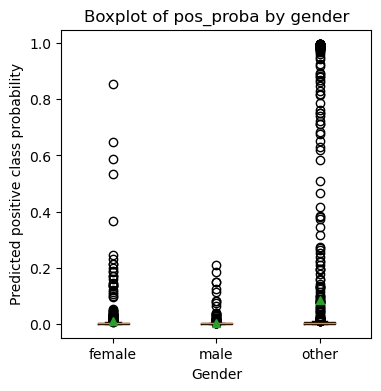

Homogeneity assumption satisfied: False
LeveneResult(statistic=75.82522113027663, pvalue=1.1729379413193833e-32)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 57.875670861099024
p = 2.706809887950743e-13
significant = True
__________________________________________________


NEU_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.9214,0.2346,0.0048,0.912,0.9307


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.9774,0.0819,0.0029,0.9717,0.9831
M,800,0.9915,0.0315,0.0011,0.9893,0.9936
Q,800,0.7952,0.3655,0.0129,0.7698,0.8206


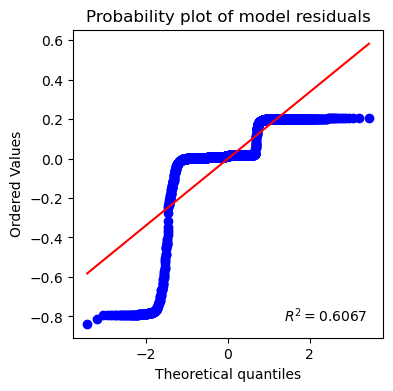

Normality assumption satisfied: False
ShapiroResult(statistic=0.6065738201141357, pvalue=0.0)


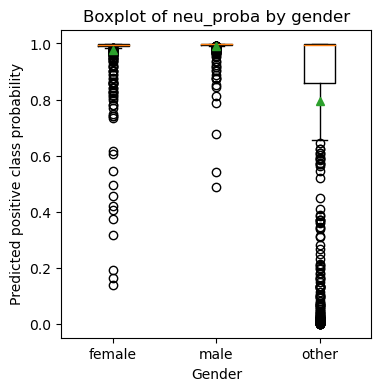

Homogeneity assumption satisfied: False
LeveneResult(statistic=204.0322740848449, pvalue=1.4880647030837792e-82)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 158.79849507120116
p = 3.291129171750251e-35
significant = True
__________________________________________________


NEG_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.0447,0.1702,0.0035,0.0379,0.0515


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0111,0.0589,0.0021,0.0070,0.0152
M,800,0.0046,0.0268,0.0009,0.0028,0.0065
Q,800,0.1183,0.2731,0.0097,0.0994,0.1373


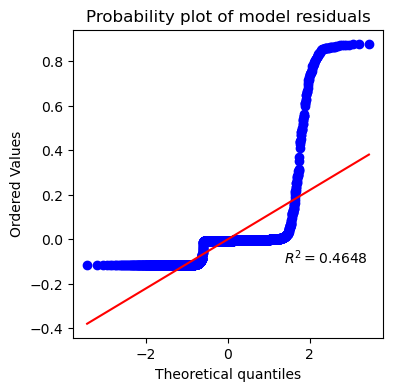

Normality assumption satisfied: False
ShapiroResult(statistic=0.46510636806488037, pvalue=0.0)


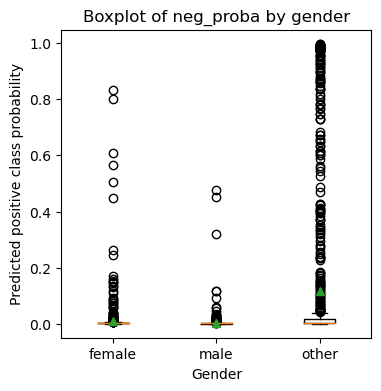

Homogeneity assumption satisfied: False
LeveneResult(statistic=124.00548849644447, pvalue=5.659857957894992e-52)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 152.39327480216525
p = 8.095074260513823e-34
significant = True
__________________________________________________




In [16]:
# bert
for sent_class in ["pos_proba", "neu_proba", "neg_proba"]:
    print(sent_class.upper())
    
    # inspect data (overall and by gender)
    display(rp.summary_cont(bert_df[sent_class]))
    display(rp.summary_cont(bert_df[sent_class].groupby(bert_df["gender"])))

    # define and fit model
    model = ols(f"{sent_class} ~ gender", data=bert_df).fit() # fit model

    # check assumptions
    # independence - assumed OK

    # normality 
    normality, n_res = check_normality(model, ALPHA, plot=True)
    print("Normality assumption satisfied:", normality)
    print(n_res)

    # homogeneity of variance
    homogeneity, h_res = check_homogeneity(bert_df, sent_class)    
    print("Homogeneity assumption satisfied:", homogeneity)
    print(h_res)

    # statistical testing
    # divide data by gender
    female = bert_df[bert_df["gender"] == "F"][sent_class]
    male = bert_df[bert_df["gender"] == "M"][sent_class]
    queer = bert_df[bert_df["gender"] == "Q"][sent_class]
    
    print("_"*50)
    
    if normality == False or homogeneity == False: # if at least one assumption is not met:
        print("\nASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST") # https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/kruskal-wallis/
        test_statistic, p = stats.kruskal(female, male, queer) # test statistic is called "H" here
    elif normality == True and homogeneity == True:
        print("\nASSUMPTIONS MET --> ANOVA")
        test_statistic, p = stats.f_oneway(female, male, queer) # test statistic is called "F" here
    print("statistic =", test_statistic)
    print("p =", p)
    print("significant =", p < 0.05)
    
    print("_"*50)
    print("\n")

#### XLM Roberta model

In [17]:
# check data types
roberta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       2400 non-null   object 
 1   sentence_DA  2400 non-null   object 
 2   pos_proba    2400 non-null   float64
 3   neu_proba    2400 non-null   float64
 4   neg_proba    2400 non-null   float64
dtypes: float64(3), object(2)
memory usage: 93.9+ KB


POS_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.0194,0.0856,0.0017,0.016,0.0229


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0268,0.1090,0.0039,0.0192,0.0343
M,800,0.0238,0.0995,0.0035,0.0169,0.0307
Q,800,0.0077,0.0038,0.0001,0.0074,0.0080


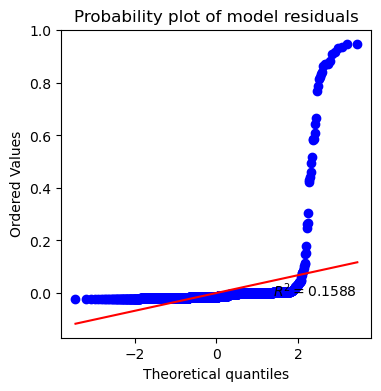

Normality assumption satisfied: False
ShapiroResult(statistic=0.15975409746170044, pvalue=0.0)


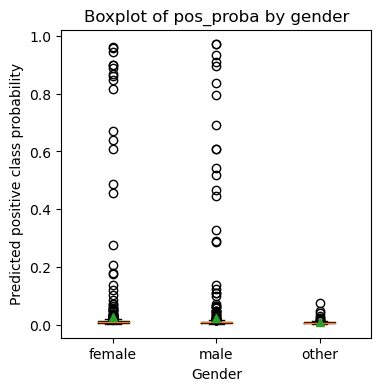

Homogeneity assumption satisfied: False
LeveneResult(statistic=10.377118824413303, pvalue=3.255916269091368e-05)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 230.2810312734273
p = 9.888021805707591e-51
significant = True
__________________________________________________


NEU_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.922,0.2062,0.0042,0.9137,0.9302


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.9171,0.2188,0.0077,0.9019,0.9323
M,800,0.9191,0.2123,0.0075,0.9044,0.9338
Q,800,0.9297,0.1862,0.0066,0.9168,0.9426


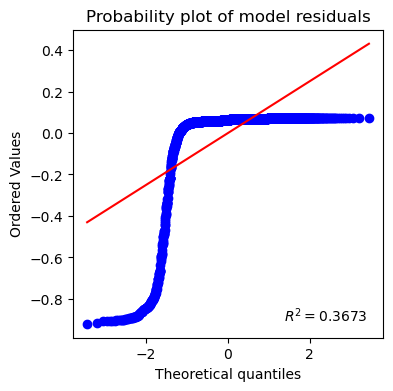

Normality assumption satisfied: False
ShapiroResult(statistic=0.3674013018608093, pvalue=0.0)


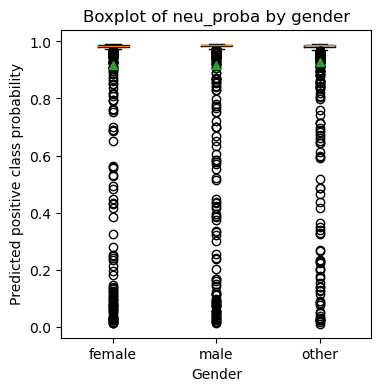

Homogeneity assumption satisfied: True
LeveneResult(statistic=0.7975749741535222, pvalue=0.4505394178905635)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 24.80799458535417
p = 4.102158363379815e-06
significant = True
__________________________________________________


NEG_PROBA




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.0586,0.1881,0.0038,0.0511,0.0661


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0561,0.1913,0.0068,0.0428,0.0694
M,800,0.0571,0.1874,0.0066,0.0441,0.0701
Q,800,0.0626,0.1856,0.0066,0.0497,0.0755


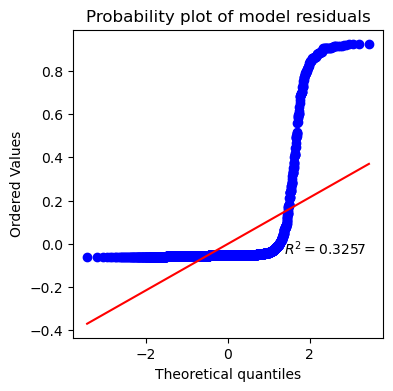

Normality assumption satisfied: False
ShapiroResult(statistic=0.3259771466255188, pvalue=0.0)


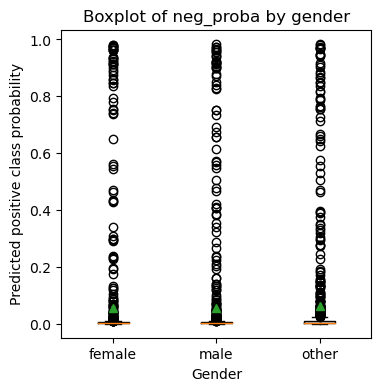

Homogeneity assumption satisfied: True
LeveneResult(statistic=0.17634133889749376, pvalue=0.8383426539256449)
__________________________________________________

ASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST
statistic = 186.89897372448922
p = 2.602576590110613e-41
significant = True
__________________________________________________




In [19]:
# roberta
for sent_class in ["pos_proba", "neu_proba", "neg_proba"]:
    print(sent_class.upper())
    
    # inspect data (overall and by gender)
    display(rp.summary_cont(roberta_df[sent_class]))
    display(rp.summary_cont(roberta_df[sent_class].groupby(roberta_df["gender"])))

    # define and fit model
    model = ols(f"{sent_class} ~ gender", data=roberta_df).fit() # fit model

    # check assumptions
    # independence - assumed OK

    # normality 
    normality, n_res = check_normality(model, ALPHA, plot=True)
    print("Normality assumption satisfied:", normality)
    print(n_res)

    # homogeneity of variance
    homogeneity, h_res = check_homogeneity(roberta_df, sent_class)    
    print("Homogeneity assumption satisfied:", homogeneity)
    print(h_res)

    # statistical testing
    # divide data by gender
    female = roberta_df[roberta_df["gender"] == "F"][sent_class]
    male = roberta_df[roberta_df["gender"] == "M"][sent_class]
    queer = roberta_df[roberta_df["gender"] == "Q"][sent_class]
    
    print("_"*50)
    
    if normality == False or homogeneity == False: # if at least one assumption is not met:
        print("\nASSUMPTIONS NOT MET --> KRUSKAL-WALLIS TEST") # https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/kruskal-wallis/
        test_statistic, p = stats.kruskal(female, male, queer) # test statistic is called "H" here
    elif normality == True and homogeneity == True:
        print("\nASSUMPTIONS MET --> ANOVA")
        test_statistic, p = stats.f_oneway(female, male, queer) # test statistic is called "F" here
    print("statistic =", test_statistic)
    print("p =", p)
    print("significant =", p < 0.05)
    
    print("_"*50)
    print("\n")

#### Bonferroni-corrected alpha for post-hoc tests

In [23]:
ADJUSTED_ALPHA = ALPHA / 3 # 3 = number of genders
print("Bonferroni-corrected alpha =", ADJUSTED_ALPHA)

Bonferroni-corrected alpha = 0.016666666666666666


### Post-hoc tests

https://www.statology.org/dunns-test-python/

#### SpaCy model

Could also just do other method, where I correct the p-values, not the alpha-level! It will be simpler for the plots!

In [79]:
dunn_res = sp.posthoc_dunn(spacy_df, val_col="neu_proba", group_col="gender")
display(dunn_res)
print("Test statistic < Bonferroni-corrected alpha:")
dunn_res < ADJUSTED_ALPHA

,F,M,Q
F,1.000000,0.000971,0.58391
M,0.000971,1.000000,0.00012
Q,0.583910,0.000120,1.00000


Test statistic < Bonferroni-corrected alpha:


,F,M,Q
F,False,True,False
M,True,False,True
Q,False,True,False


In [80]:
# visualize this
# Code taken from: https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html
# see https://github.com/trevismd/statannotations-tutorials/blob/main/Tutorial_1/Statannotations-Tutorial-1.ipynb as well

# remove redundant comparisons
remove = np.tril(np.ones(dunn_res.shape), k=0).astype("bool")
dunn_res[remove] = np.nan

# melt df
molten_df = dunn_res.melt(ignore_index=False).reset_index().dropna()
molten_df

,index,variable,value
3,F,M,0.000971
6,F,Q,0.583910
7,M,Q,0.000120


In [48]:
import seaborn as sns
from statannotations.Annotator import Annotator

p-value annotation legend:
      ns: 1.67e-02 < p <= 1.00e+00
       *: 3.33e-03 < p <= 1.67e-02
      **: 3.33e-04 < p <= 3.33e-03
     ***: 3.33e-05 < p <= 3.33e-04
    ****: p <= 3.33e-05

F vs. M: Custom statistical test, P_val:9.706e-04
M vs. Q: Custom statistical test, P_val:1.198e-04
F vs. Q: Custom statistical test, P_val:5.839e-01


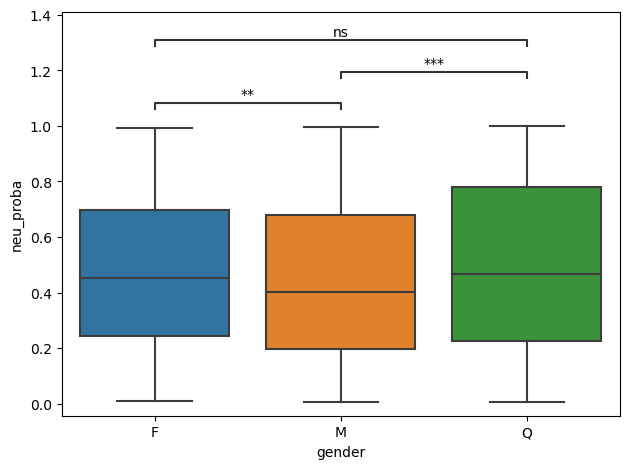

In [81]:
ax = sns.boxplot(data=spacy_df, x="gender", y="neu_proba", order=["F", "M", "Q"])

pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]

annotator = Annotator(
    ax, pairs, data=spacy_df, x="gender", y="neu_proba", order=["F", "M", "Q"])
annotator.configure(text_format="star", loc="inside", alpha=ADJUSTED_ALPHA, pvalue_thresholds=[[0.0001/3, '****'], [0.001/3, '***'], [0.01/3, '**'], [0.05/3, '*'], [1, 'ns']])
annotator.set_pvalues_and_annotate(p_values)

# original thresholds
#       ns: 0.05 < p <= 1.00
#        *: 0.01 < p <= 0.05
#       **: 0.001 < p <= 0.01
#      ***: 0.0001 < p <= 0.001
#     ****: p <= 0.0001

# new thresholds
#       ns: 0.5/3 < p <= 1.00
#        *: 0.01/3 < p <= 0.5/3
#       **: 0.001/3 < p <= 0.01/3
#      ***: 0.0001/3 < p <= 0.001/3
#     ****: p <= 0.0001/3

plt.tight_layout()
plt.show()

F vs. M: Custom statistical test, P_val:2.912e-03
M vs. Q: Custom statistical test, P_val:3.593e-04
F vs. Q: Custom statistical test, P_val:1.000e+00


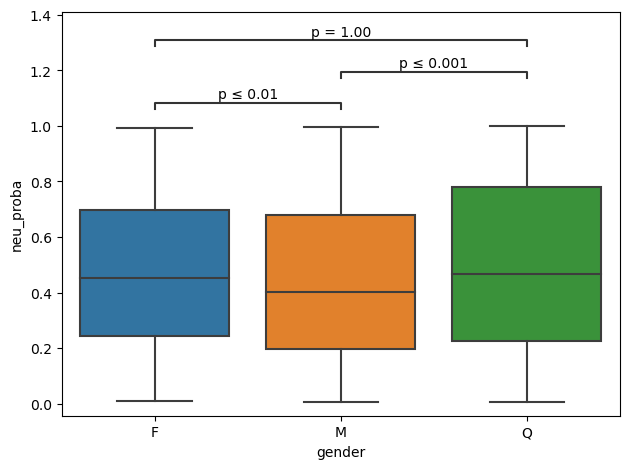

In [77]:
# A VERSION WITH SIMPLE ANNOTATION INSTEAD OF STARS AND WHERE THE PVALUES ARE ADJUSTED NOT THE ALPHA-LEVEL!!


dunn_res2 = sp.posthoc_dunn(spacy_df, val_col="neu_proba", group_col="gender", p_adjust="bonferroni")

# remove redundant comparisons
remove = np.tril(np.ones(dunn_res2.shape), k=0).astype("bool")
dunn_res2[remove] = np.nan

# melt df
molten_df = dunn_res2.melt(ignore_index=False).reset_index().dropna()
molten_df

ax = sns.boxplot(data=spacy_df, x="gender", y="neu_proba", order=["F", "M", "Q"])

pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]

annotator = Annotator(
    ax, pairs, data=spacy_df, x="gender", y="neu_proba", order=["F", "M", "Q"])
annotator.configure(text_format="simple", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.tight_layout()
plt.show()

Significant: female-male, and male-queer

Not-significant: female-queer

#### BERT Tone model

#### XLM Roberta model

### Assumptions

Take a look at predicted positive class probabilities for the spacy model

#### Independence

"This assumption is tested when the study is designed. What this means is that all groups are mutually exclusive, i.e. an individual can only belong in one group. Also, this means that the data is not repeated measures (not collected through time). In this example, this condition is met." - https://www.pythonfordatascience.org/anova-python/

#### Normality

Absence of normality might not be a problem.

**Central Limit Theorem**: "It means that if the sample size is large enough then normality may not be a concern even if the test for normality indicates that normality is not present. Simulation studies have been conducted and the general rule of thumb is n ≥ 30."

But could also just choose a non-parametric test instead, if there's an absence of normality.

"What if Normality is Violated?

If the assumption of normality is violated fear not! There are a few routes to consider, these are in no particular order:

* Rely on the Central Limit Theorem if the sample size is large enough (>= 30)
* Use a non-parametric statistical test
* Transform the data" 

Source: https://www.pythonfordatascience.org/parametric-assumptions-python/

In [82]:
model = ols("pos_proba ~ gender", data=spacy_df).fit() # fit model
stats.shapiro(model.resid) # (W-test statistic, p-value)

# This is significant, i.e. non-normal residuals!!!

ShapiroResult(statistic=0.9268395900726318, pvalue=1.0451825735731812e-32)

In [83]:
# another type of test (D'Agostino-Pearson K2 test) -- see https://www.pythonfordatascience.org/parametric-assumptions-python/
stats.normaltest(model.resid)

NormaltestResult(statistic=2684.9822631539823, pvalue=0.0)

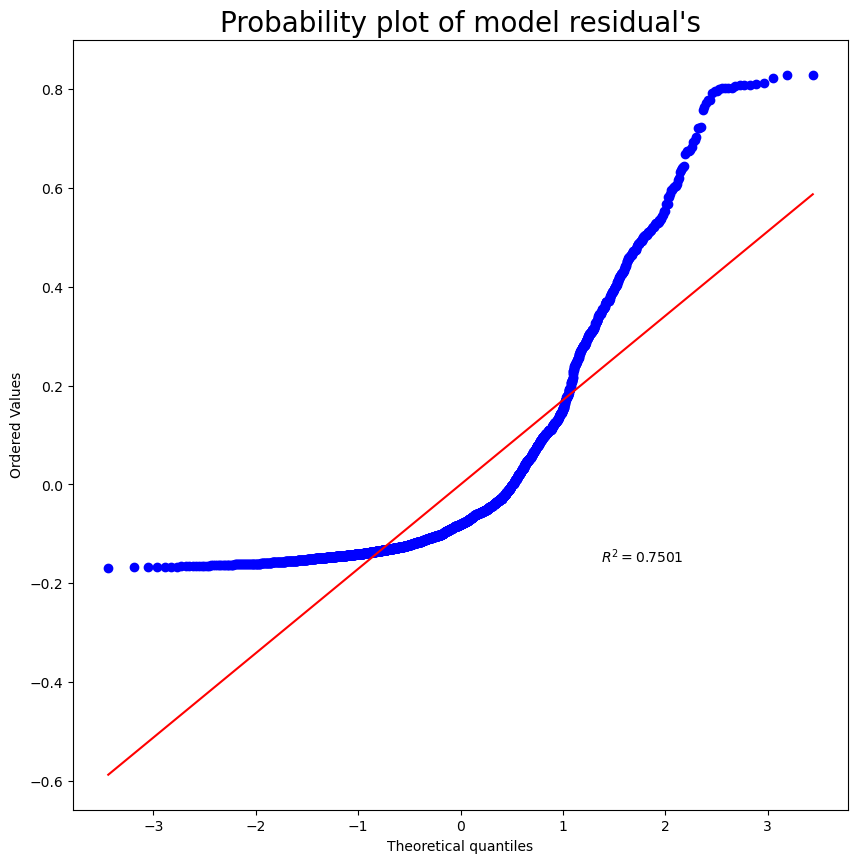

In [103]:
# visualize it 
# code copied from https://www.pythonfordatascience.org/anova-python/
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot=plt, rvalue=True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

# also not met here!

#### Homogeneity of variance

"What if homogeneity of variances is violated?

If there is not equal variances between groups there are a few routes to consider, these are in no particular order:

* Use a non-parametric statistical test
* Transform the data"

Source: https://www.pythonfordatascience.org/parametric-assumptions-python/

In [ ]:
# levene's test is less sensitive to departures from normality and power than bartlett's test
stats.levene(spacy_df["pos_proba"][spacy_df["gender"] == "F"],
            spacy_df["pos_proba"][spacy_df["gender"] == "M"],
            spacy_df["pos_proba"][spacy_df["gender"] == "Q"])

# not significant (i.e. this assumption is met)

LeveneResult(statistic=2.8817304092960634, pvalue=0.05623187748159622)

In [79]:
stats.bartlett(spacy_df["pos_proba"][spacy_df["gender"] == "F"],
            spacy_df["pos_proba"][spacy_df["gender"] == "M"],
            spacy_df["pos_proba"][spacy_df["gender"] == "Q"])

# not significant (i.e. this assumption is met)

BartlettResult(statistic=3.2028022726695116, pvalue=0.20161383153481463)

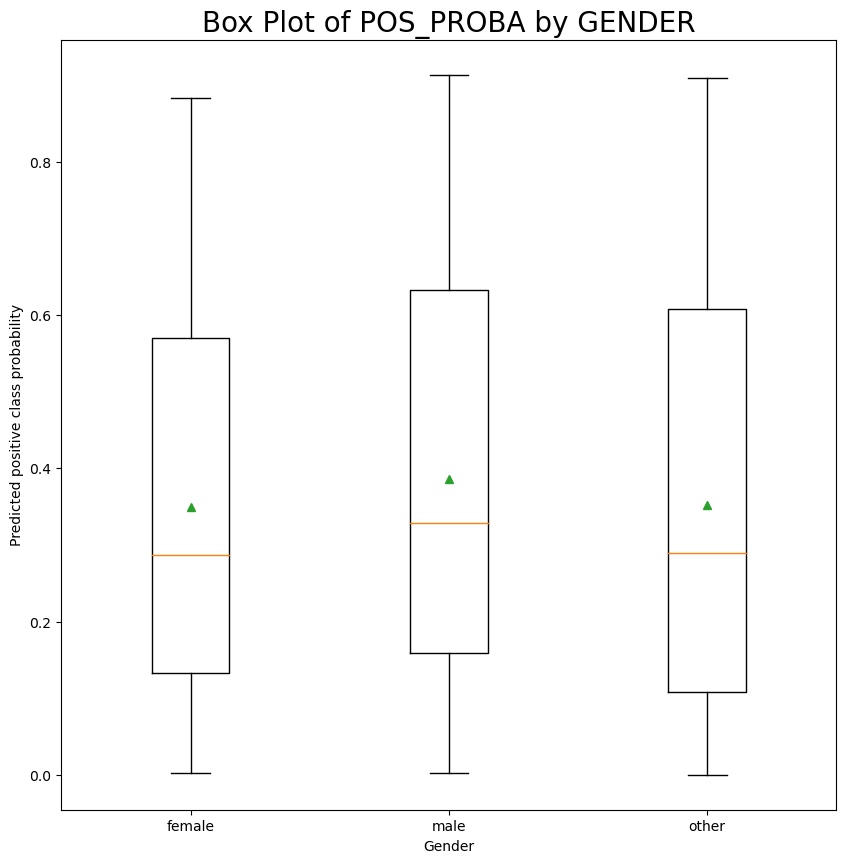

In [78]:
# visual check
# again copied code from: https://www.pythonfordatascience.org/anova-python/ 

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of POS_PROBA by GENDER", fontsize= 20)
ax.set

data = [spacy_df["pos_proba"][spacy_df["gender"] == "F"],
        spacy_df["pos_proba"][spacy_df["gender"] == "M"],
        spacy_df["pos_proba"][spacy_df["gender"] == "Q"]]

ax.boxplot(data, labels=['female', 'male', 'other'], showmeans=True)

plt.xlabel("Gender")
plt.ylabel("Predicted positive class probability")

plt.show()

### ANOVAs

In [ ]:
# # https://www.pythonfordatascience.org/anova-python/
# # General structure: ols("outcome_variable ~ independent_variable", data= data_frame).fit()

# model = ols("sentiment_score ~ NP_gender", data=df).fit()
# aov_table = sm.stats.anova_lm(model, typ=2) # read more here: https://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html
# aov_table

# see https://www.pythonfordatascience.org/anova-python/ for how to calculate the eta- and omega-square

In [45]:
# for each sentiment class, perform an ANOVA

for sent_class in ["pos_proba", "neu_proba", "neg_proba"]:
    model = ols(f"{sent_class} ~ gender", data=spacy_df).fit() # fit model
    aov_table = sm.stats.anova_lm(model, typ=2) # generate table
    print(f"{sent_class.upper()} (significant = {aov_table.loc['gender', 'PR(>F)'] < ALPHA})\n")
    print(aov_table)
    print("_"*50)

# gender = between samples, residual = within samples

POS_PROBA (significant = True)

              sum_sq      df        F    PR(>F)
gender      0.646690     2.0  4.63256  0.009817
Residual  167.306623  2397.0      NaN       NaN
__________________________________________________
NEU_PROBA (significant = True)

              sum_sq      df         F    PR(>F)
gender      1.312106     2.0  8.528574  0.000204
Residual  184.387087  2397.0       NaN       NaN
__________________________________________________
NEG_PROBA (significant = False)

             sum_sq      df         F    PR(>F)
gender     0.196113     2.0  2.526618  0.080142
Residual  93.025870  2397.0       NaN       NaN
__________________________________________________


In [46]:
# use the other method, should give the exact same results!

import scipy.stats as stats
for sent_class in ["pos_proba", "neu_proba", "neg_proba"]:
    female = spacy_df[spacy_df["gender"] == "F"][sent_class]
    male = spacy_df[spacy_df["gender"] == "M"][sent_class]
    queer = spacy_df[spacy_df["gender"] == "Q"][sent_class]
    aov_res = stats.f_oneway(female, male, queer)
    print(f"{sent_class.upper()} (significant = {aov_res.pvalue < ALPHA})\n")
    print(aov_res)
    print("_"*50)

POS_PROBA (significant = True)

F_onewayResult(statistic=4.632559559763703, pvalue=0.00981710062125248)
__________________________________________________
NEU_PROBA (significant = True)

F_onewayResult(statistic=8.528573998164065, pvalue=0.000203799813178895)
__________________________________________________
NEG_PROBA (significant = False)

F_onewayResult(statistic=2.5266184924931485, pvalue=0.08014169820997194)
__________________________________________________


In [89]:
# Kruskal-Wallis test
# https://library.virginia.edu/data/articles/getting-started-with-the-kruskal-wallis-test

for sent_class in ["pos_proba", "neu_proba", "neg_proba"]:
    female = spacy_df[spacy_df["gender"] == "F"][sent_class]
    male = spacy_df[spacy_df["gender"] == "M"][sent_class]
    queer = spacy_df[spacy_df["gender"] == "Q"][sent_class]
    kw_res = stats.kruskal(female, male, queer)
    print(f"{sent_class.upper()} (significant = {kw_res.pvalue < ALPHA})\n")
    print(kw_res)
    print("_"*50)

POS_PROBA (significant = True)

KruskalResult(statistic=9.926251858601063, pvalue=0.006991040143498195)
__________________________________________________
NEU_PROBA (significant = True)

KruskalResult(statistic=17.319320184297794, pvalue=0.00017344325160799655)
__________________________________________________
NEG_PROBA (significant = True)

KruskalResult(statistic=11.000519346105648, pvalue=0.004085710351822214)
__________________________________________________


In [136]:
stats.kruskal(female, male, queer)

KruskalResult(statistic=11.000519346105648, pvalue=0.004085710351822214)

In [135]:
p

0.004085710351822214